# Applying the Hidden Markov Model on Budget allocation

The hidden markov model would recommend a budget using conversion state transitions, budget emissions, and return on investment indicators 

### Objective
Minimize the budget _B<sub>t</sub>_ to transition from state _S<sub>t</sub>_ to _S<sub>t+1</sub>_

### Subject to
* Sum of _B<sub>t</sub>_ <= _B_;  for all _t_
* RMS of _R_ <= $\epsilon$; where _R_ is the Residual of the expected and actual return on investmenet _B_
* Sum of _S<sub>t+1</sub> - S<sub>t</sub>_ <= _T_; where _T_ is the total allowable time period to complete all transitions from S<sub>start</sub> to S<sub>final</sub>

#### Reference
[Analyzing Time Series Data with Markov Transition Matrices](https://medium.com/towards-data-science/time-series-data-markov-transition-matrices-7060771e362b)

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'
import traceback

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True


## Instantiate Classes

In [2]:
import os
import sys
import numpy as np
from pyspark.sql import functions as F
import tensorflow_probability as tfp
import tensorflow as tf

proj_dir = os.path.abspath(os.pardir)
sys.path.insert(1,proj_dir.split('mining/')[0])
from rezaware.modules.etl.loader import sparkRDBM as db
from rezaware.modules.etl.loader import sparkFile as file
# from rezaware.modules.etl.loader import __propAttr__ as attr

''' restart initiate classes '''
if debug:
    import importlib
    db = importlib.reload(db)
    file=importlib.reload(file)
    # attr=importlib.reload(attr)

__desc__ = "read and write BigQuery dataset for hypothese testing"
# clsSDB = db.dataWorkLoads(
#     desc=__desc__,
#     db_type = 'bigquery',
#     db_driver=None,
#     db_hostIP=None,
#     db_port = None,
#     db_name = None,
#     db_schema='combined_data_facebook_ads',
#     spark_partitions=None,
#     spark_format = 'bigquery',
#     spark_save_mode=None,
#     # spark_jar_dir = _jar,
# )
clsFile = file.dataWorkLoads(
    desc = "optimizing action_type budgets for an ad",
    store_mode='local-fs',
    store_root=proj_dir.split('mining/')[0],
    jar_dir=None,
)
# if clsSDB.session:
#     clsSDB._session.stop
print("\n%s class initialization and load complete!" % __desc__)

2025-02-24 07:57:26.675447: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-24 07:57:26.679185: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-24 07:57:26.691541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740355046.713461   87979 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740355046.719686   87979 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 07:57:26.741106: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

All functional __PROPATTR__-libraries in LOADER-package of ETL-module imported successfully!
All functional SPARKRDBM-libraries in LOADER-package of ETL-module imported successfully!
All functional SPARKFILE-libraries in LOADER-package of ETL-module imported successfully!
All functional SPARKRDBM-libraries in LOADER-package of ETL-module imported successfully!
All functional SPARKFILE-libraries in LOADER-package of ETL-module imported successfully!
All functional APP-libraries in REZAWARE-package of REZAWARE-module imported successfully!
__propAttr__ Class initialization complete
__propAttr__ Class initialization complete
sparkFile Class initialization complete

read and write BigQuery dataset for hypothese testing class initialization and load complete!


## Load data

In [3]:
from pyspark.sql.functions import unix_timestamp

options = {
    "inferSchema":True,
    "header":True,
    "delimiter":",",
    "pathGlobFilter":'*.csv',
    "recursiveFileLookup":True,
}

#### Action Types

In [4]:
_fname = "action_types.csv"
_fpath = "mining/data/budget/"
_act_sdf=clsFile.read_files_to_dtype(
    as_type = "SPARK",      # optional - define the data type to return
    folder_path=_fpath,  # optional - relative path, w.r.t. self.storeRoot
    file_name=_fname,  # optional - name of the file to read (complete-60-accounts.csv)
    file_type=None,  # optional - read all the files of same type
    **options,
)
print("Loaded %s %d rows" % (_fname, _act_sdf.count()))

25/02/24 07:59:20 WARN Utils: Your hostname, Waidy-Think-Three resolves to a loopback address: 127.0.1.1; using 192.168.2.82 instead (on interface enp0s25)
25/02/24 07:59:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/02/24 07:59:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/24 07:59:23 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Loaded action_types.csv 101 rows


#### Action group list

With data = {app_interactions, checkout, custom_conversions, lead_generation, purchase, registration, }

In [5]:
_act_grp_lst = [x['action_group'] for x in
                          _act_sdf.select(F.col('action_group'))\
                          .distinct().orderBy(F.col('action_group')).collect()]
print("Action group list: \n", ", ".join(_act_grp_lst))

Action group list: 
 app_interactions, awareness, checkout, custom_conversions, engagement, lead_generation, purchase, registration, search, subscriptions, trial_and_demos


In [1]:
_act_grp = "custom_conversions"
_grp_act_lst = [x['action_type'] for x in 
                _act_sdf.select(F.col('action_type'))\
                    .where(F.col('action_group').isin(_act_grp))\
                    .collect()]
print("action types for group:",_act_grp.upper())
print(", ".join(_grp_act_lst))

NameError: name '_act_sdf' is not defined

In [126]:
_act_cols_lst = [x for x in sdf.columns if x.find(_act_grp)==0]
print(", ".join(_act_cols_lst))

lead_generation_onsite_conversion__lead_grouped, lead_generation_offsite_conversion__fb_pixel_lead, lead_generation_lead, lead_generation_leadgen_grouped


In [127]:
count_dict= {}
for act  in _act_cols_lst:
    count_dict[act]=sdf.select(act).dropna().count()
count_dict

{'lead_generation_onsite_conversion__lead_grouped': 3,
 'lead_generation_offsite_conversion__fb_pixel_lead': 30701,
 'lead_generation_lead': 31039,
 'lead_generation_leadgen_grouped': 0}

#### Full Dataset

In [11]:
_fname = "FullDataset.csv"
sdf=clsFile.read_files_to_dtype(
    as_type = "SPARK",      # optional - define the data type to return
    folder_path=_fpath,  # optional - relative path, w.r.t. self.storeRoot
    file_name=_fname,  # optional - name of the file to read (complete-60-accounts.csv)
    file_type=None,  # optional - read all the files of same type
    **options,
)
print("Loaded %s %d rows" % (_fname, sdf.count()))# sdf.printSchema()
''' convert date to int '''
sdf = sdf.withColumn('date', unix_timestamp('updated_time'))
print("timestamp converted unix_timestamp for %d rows" % sdf.count())


Loaded FullDataset.csv 1777681 rows


[Stage 55:==============================================>           (4 + 1) / 5]

timestamp converted unix_timestamp for 1777681 rows


In [115]:
sdf.groupBy('objective').count().show()

+--------------------+-------+
|           objective|  count|
+--------------------+-------+
|        APP_INSTALLS|  10753|
|     POST_ENGAGEMENT|    910|
|               REACH|     81|
|            MESSAGES|    944|
|   OUTCOME_AWARENESS|  20332|
|PRODUCT_CATALOG_S...|  16081|
|         LINK_CLICKS|  71717|
|       OUTCOME_LEADS|  58280|
|  OUTCOME_ENGAGEMENT|  33818|
|     LEAD_GENERATION|   1145|
|         VIDEO_VIEWS|    127|
|         CONVERSIONS|  59053|
|       OUTCOME_SALES|1504435|
|          PAGE_LIKES|      4|
|     BRAND_AWARENESS|      1|
+--------------------+-------+



In [44]:
sdf.printSchema()

root
 |-- account_id: long (nullable = true)
 |-- ad_id: long (nullable = true)
 |-- adset_id: long (nullable = true)
 |-- campaign_id: long (nullable = true)
 |-- updated_time: date (nullable = true)
 |-- impressions: integer (nullable = true)
 |-- frequency: double (nullable = true)
 |-- reach: integer (nullable = true)
 |-- CTR: double (nullable = true)
 |-- CPP: double (nullable = true)
 |-- CPC: double (nullable = true)
 |-- CPM: double (nullable = true)
 |-- spend: double (nullable = true)
 |-- clicks: integer (nullable = true)
 |-- auction_bid: string (nullable = true)
 |-- objective: string (nullable = true)
 |-- account_currency: string (nullable = true)
 |-- business_country_code: string (nullable = true)
 |-- business_city: string (nullable = true)
 |-- business_state: string (nullable = true)
 |-- timezone_name: string (nullable = true)
 |-- d1_view: double (nullable = true)
 |-- d7_view: double (nullable = true)
 |-- d28_view: double (nullable = true)
 |-- d1_click: double

In [4]:
__def_geom__ = 'NYC,USA'
__def_demog__= [{"age":'35-55', "male": 0.60, "female": 0.37, "unknown": 0.03}]
__def_obj__ = 'APP_INSTALLS'
__def_goal__= 'OFFSITE_CONVERSIONS'  # action group
__def_model_name__="_".join([__def_goal__,])

__def_obs_cols__= ['spend','impressions', 'clicks', 'reach', 'frequency']
__def_dt_cols__ = ['date']
__def_tran_lst__ =_act_cols_lst #['impressions', 'click', 'reach']
__def_feats_lst__=[&__def_dt_cols__,  ]
__def_emm_lst__ = ['ROAS','CPC','CTR','CPM']
''' wihout updated_time', 'spend_usd', 'impressions', 'click', 'reach', 'frequency '''
# _goal_df= sdf.select('date','spend_usd', 'impressions', 'click', 'reach', 'frequency',
#                      'ROAS','CPC','CTR','CPM')\

_emmis_df= sdf.select(*__def_emm_lst__, *__def_tran_lst__) \
            .where(F.col('goal').isin(__def_goal__)) \
            .dropna().toPandas()
print("emmisions df shape:", _emmis_df.shape)
print("emssisions df stats:\n", _emmis_df.describe())

_tran_prob_df= sdf.select(__def_feats_lst__) \
            .where(F.col('goal').isin(__def_goal__)) \
            .dropna().orderBy('updated_time').toPandas()
print("transition probabilities df shape:", _tran_prob_df.shape)
print("transition probabilities df stats:\n", _tran_prob_df.describe())

_label_df = sdf.select(*__def_obs__) \
            .where(F.col('goal').isin(__def_goal__)) \
            .dropna().orderBy('updated_time').toPandas()
print("observations df shape:", _tran_prob_df.shape)
print("observations df stats:\n", _label_df.describe())

emmisions df shape: (24670, 7)
emssisions df stats:
                ROAS           CPC           CTR           CPM   impressions  \
count  24670.000000  24670.000000  24670.000000  24670.000000  2.467000e+04   
mean       6.772952      5.364572      3.646024    109.382239  1.407236e+04   
std      106.486162      6.781688      3.773560    113.130134  3.668238e+04   
min        0.000332      0.000000      0.000000      0.545455  1.000000e+00   
25%        0.679807      1.207814      1.388103     37.305505  1.519000e+03   
50%        1.404545      3.006176      2.389706     71.853380  4.904000e+03   
75%        3.038977      6.994643      4.421769    147.826330  1.401450e+04   
max    10100.000000    139.398333     50.000000   3668.377193  1.873861e+06   

               click         reach  
count   24670.000000  2.467000e+04  
mean      570.365302  1.214955e+04  
std      2667.583861  3.130191e+04  
min         0.000000  1.000000e+00  
25%        34.000000  1.284000e+03  
50%       112

transition probabilities df shape: (56309, 5)
transition probabilities df stats:
                date   impressions          click         reach     frequency
count  5.630900e+04  5.630900e+04   56309.000000  5.630900e+04  56309.000000
mean   1.730340e+09  7.318835e+03     306.342166  6.316045e+03      0.987710
std    5.082494e+06  2.551094e+04    1856.726374  2.181607e+04      0.463990
min    1.696262e+09  0.000000e+00       0.000000  0.000000e+00      0.000000
25%    1.726502e+09  1.810000e+02       4.000000  1.530000e+02      1.051282
50%    1.730909e+09  1.394000e+03      32.000000  1.186000e+03      1.116855
75%    1.734451e+09  5.682000e+03     144.000000  4.761000e+03      1.203747
max    1.738858e+09  1.873861e+06  165274.000000  1.506747e+06      3.500000
observations df shape: (56309, 5)
observations df stats:
           spend_usd
count  56309.000000
mean      29.966158
std       96.009231
min        0.000000
25%        0.840840
50%        4.980720
75%       18.213720
max    

## Implement the Belman equation
The [Belman equation](https://www.datacamp.com/tutorial/bellman-equation-reinforcement-learning) has the following componensts:
1. R(s,a): The immediate reward received for taking action aaa in state sss.
2. γ: The discount factor (between 0 and 1) that determines the importance of future rewards compared to immediate rewards.
3. P(s′∣s,a) The probability of transitioning to state s′ from state sss by taking action a.
4. max⁡(a): The optimal action that maximizes the expected value of future rewards.

### Filter and Separate dataset
1. Transition matrix features and values
2. Emission matrix features and values
3. Observed outcomes

### Compute the transition probabilities

[[0.09515828 0.04185669 0.86298504]
 [0.         1.         0.        ]
 [0.         0.         1.        ]]


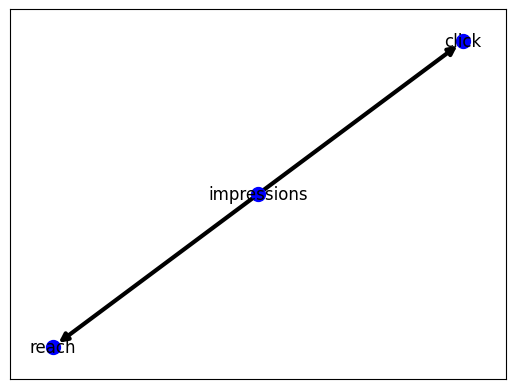

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edges_from([('impressions', 'click'), ('impressions', 'reach')])

i=0
for _node in G.nodes:
    G.add_node(_node, stateid=i, emission=0.0)
    i+=1

_trans_matrix = np.zeros((int(G.number_of_nodes()),int(G.number_of_nodes())),dtype=float)

''' transition probabilities '''
for u, v in G.edges():
    u_count = _tran_prob_df[u].sum()
    v_count = _tran_prob_df[v].sum()
    if v_count <= u_count:
        _trans_matrix[G.nodes[u]['stateid'],G.nodes[v]['stateid']]=float(v_count/u_count)
''' fill the diagnals '''
for i in range(0,_trans_matrix.shape[0],1):
    if _trans_matrix[i,].sum() <= 1.0:
        _trans_matrix[i,i]=1.0-_trans_matrix[i,].sum()
    else:
        _trans_matrix[i,i]=1.0
print(_trans_matrix)

options = {
    'node_color': 'blue',
    'node_size': 100,
    'width': 3,
    'arrowstyle': '-|>',
    'arrowsize': 12,
}
nx.draw_networkx(G, arrows=True, **options)

### Compute the emission probabilities

In [101]:
_emmi_lst = []
for _state in _emmis_df[__def_tran_lst__].columns:
    _state_sum = _emmis_df[_state].sum()
    _emmi_lst.append((_emmis_df[__def_emm_lst__]/_row_sum).sum())
_emm_matrix = np.array(_emmi_lst[0])
print("_emissions\n",_emm_matrix.shape, "\n", _emm_matrix)
    # for col in _emmis_df[__def_emm_lst__].columns:
        # _col_sum = _emmis_df[col].sum()
        # print(_col_sum/_row_sum)

_emissions
 (4,) 
 [0.00055747 0.00044154 0.0003001  0.00900299]


In [106]:
from hmmlearn.hmm import MultinomialHMM

_observations = np.array(_emmis_df[__def_tran_lst__])

model = MultinomialHMM(
    n_components=_trans_matrix.shape[1],
    startprob_prior=_emm_matrix,
    algorithm='viterbi',
    random_state=0,
    n_iter=100,
)
model.fit(_observations)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


ValueError: operands could not be broadcast together with shapes (4,) (3,) 

In [7]:
### DEPRECATED

import collections
import numpy as np
from itertools import chain

# _state_trans = [
#     ('omni_view_content_value','omni_add_to_cart_value'),
#     ('omni_view_content_value', 'omni_initiated_checkout_value'),
#     ('omni_add_to_cart_value', 'omni_purchase_value'),
#     ('omni_initiated_checkout_value', 'omni_purchase_value'),
# ]
# 'impressions', 'click', 'reach'
_state_trans = {
    0:('impressions','click'),
    1:('impressions', 'reach'),
}
_state_trans=collections.OrderedDict(sorted(_state_trans.items()))
print(_state_trans)
''' discover the states from the transition meta data '''
_states = list(set(list(chain(*[_state_trans[k] for k in _state_trans.keys()]))))
print(_states)
_trans_matrix = np.zeros((len(_states),len(_states)))

for i in range(0,len(_states),1):
    for j in range(0,len(_states),1):
        print(_states[i],_states[j])
        if (_states[i],_states[j]) in _state_trans:
            # print(_states[i],_states[j])
            _trans_matrix[i,j]=10
_trans_matrix

# _max_states = len(_state_trans)

# for _trans in _state_trans:
#     _from_state, _to_state = _state_trans[_trans][0], _state_trans[_trans][1]
#     print(_from_state, _to_state)

OrderedDict([(0, ('impressions', 'click')), (1, ('click', 'reach'))])
['impressions', 'reach', 'click']
impressions impressions
impressions reach
impressions click
reach impressions
reach reach
reach click
click impressions
click reach
click click


array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])